## Goal: Create a Convolutional Neural Network to identify galaxy types using the Galaxy10 dataset
## Code Author: Meredith Vogel

- Galaxy10 only contains images for which more than 55% of the votes agree on the class. That is, more than 55% of the votes among 10 classes are for a single class for that particular image. If none of the classes get more than 55%, the image will not be included in Galaxy10 as no agreement was reached. 
- 21785 images are left after the cut and have 1 of 10 labels. The original images are 424x424, but were cropped to 207x207 centered at the images and then downscaled 3 times via bilinear interpolation to 69x69 in order to make them manageable on most computer and graphics card memory.

## Import Packages and load the galaxy data images and their labels

In [45]:
from astroNN.datasets import galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup
import keras
from keras import Model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing import image
import numpy as np
from timeit import default_timer as timer
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
images, labels = galaxy10.load_data()
print(images.shape, labels.shape)

/home/mvogel1/.astroNN/datasets/Galaxy10.h5 was found!
(21785, 69, 69, 3) (21785,)


## How many unique labels are there? How many images belong to each unique label?

In [3]:
unique, counts = np.unique(labels, return_counts=True)
#print(f'unique labels: {unique}, number of images for each label: {counts}')

Galaxy10 dataset (21,785 images)
- Class 0 (3461 images): Disk, Face-on, No Spiral
- Class 1 (6997 images): Smooth, Completely round
- Class 2 (6292 images): Smooth, in-between round
- Class 3 (394 images): Smooth, Cigar shaped
- Class 4 (1534 images): Disk, Edge-on, Rounded Bulge
- Class 5 (17 images): Disk, Edge-on, Boxy Bulge
- Class 6 (589 images): Disk, Edge-on, No Bulge
- Class 7 (1121 images): Disk, Face-on, Tight Spiral
- Class 8 (906 images): Disk, Face-on, Medium Spiral
- Class 9 (519 images): Disk, Face-on, Loose Spiral

In [4]:
images = images.astype(np.float32)/255

- Since 255 is the maximum value, dividing by 255 expresses a 0-1 representation. Each channel (Red, Green, and Blue are each channels) is 8 bits, so they are each limited to 256, in this case 255 since 0 is included. 
- systems typically use values between 0-1 when using floating point values.

## There are 21785 images with 69 by 69 pixels with 3 (RGB) channels. The 10 types are visualized below:

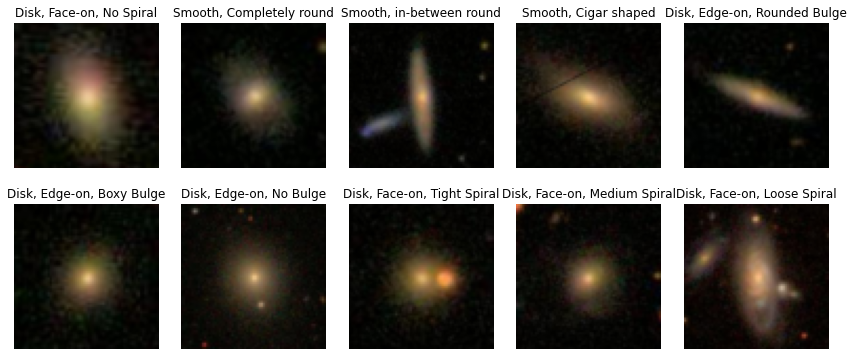

In [5]:
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .25, wspace=.001)
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(images[i])
    axs[i].set_title(galaxy10cls_lookup(int(i)))
    axs[i].axis('off')
plt.show()

## Previous Results with Fix
- The CNN performs poorly when all 10 classes of galaxies are used. The average accuracy (although the dataset is not balanced) is 68.75%, the overall precision is 68.33% and the overall recall for the classes is 68.75%.

- A high precision and low recall typically indicates that the model is good at identifying positive instances, but it may be missing some of the actual positive instances.

- A high precision means that the proportion of true positive predictions among all positive predictions is high. This means that when the model predicts a positive instance, it is likely to be correct. However, a low recall means that the model is missing some of the actual positive instances and may be incorrectly predicting them as negative.

- This situation may occur when the model is overly conservative in its predictions, i.e., it is hesitant to make positive predictions unless it is very confident that the instance is indeed positive. This can lead to a high precision but low recall.

- Looking at the images in the plot above, one could say around half of the images look very similar and by eye they would be hard to differentiate, therefore the model would also have a hard time differentiating. I will remove classes 5-8 since they mostly look like class 1 (the classes start at 0, therefore the last class is 9) and have the model perform only on classes 0-4 and 9.

In [6]:
# Define the classes to exclude
values_to_exclude = [5, 6, 7, 8]

# Create a boolean mask to identify classes to keep
keep_mask = ~np.isin(labels, values_to_exclude)

# Create new label and images arrays excluding classes 5-8
filtered_labels = labels[keep_mask]
filtered_images = images[keep_mask]

print(filtered_labels.shape, filtered_images.shape)

(19152,) (19152, 69, 69, 3)


In [9]:
# To convert the labels to 10 categorical classes
filtered_labels = to_categorical(filtered_labels, 10)

# To convert to desirable type
filtered_labels = filtered_labels.astype(np.float32)

In [10]:
X = filtered_images
y = filtered_labels

In [11]:
# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=42, shuffle=True)

In [12]:
# reshape the arrays
imsize = np.shape(X_train)[2]
input_shape = (imsize, imsize, 3)

X_train = X_train.reshape(-1, imsize, imsize, 3)
X_valid = X_valid.reshape(-1, imsize, imsize, 3)
X_test = X_test.reshape(-1, imsize, imsize, 3)

In [13]:
# create a sequential CNN
model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3), activation='relu', padding='same', input_shape=(69,69,3)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, kernel_size = (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax', name = 'final'))
model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, to_file = 'network_layout.png')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 69, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 18496)             0         
                                                                 
 dropout (Dropout)           (None, 18496)             0

In [14]:
# compile the model and time how long it takes to train and validate on the dataset
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

start = timer()
history = model.fit(X_train, y_train, batch_size = 128, epochs=30, validation_data=(X_valid, y_valid), shuffle=True, 
          callbacks=EarlyStopping(monitor='val_loss', patience=2))
end = timer()

print(f'elapsed time: {(end-start)/60} minutes')

Epoch 1/30
105/105 [==============================] - 60s 565ms/step - loss: 1.3527 - accuracy: 0.4140 - val_loss: 1.1795 - val_accuracy: 0.4961
Epoch 2/30
105/105 [==============================] - 60s 567ms/step - loss: 1.1316 - accuracy: 0.5069 - val_loss: 1.0611 - val_accuracy: 0.5201
Epoch 3/30
105/105 [==============================] - 60s 567ms/step - loss: 1.0142 - accuracy: 0.5640 - val_loss: 0.9746 - val_accuracy: 0.5789
Epoch 4/30
105/105 [==============================] - 59s 565ms/step - loss: 0.9341 - accuracy: 0.6011 - val_loss: 0.9312 - val_accuracy: 0.5836
Epoch 5/30
105/105 [==============================] - 59s 565ms/step - loss: 0.8668 - accuracy: 0.6390 - val_loss: 0.9476 - val_accuracy: 0.5821
Epoch 6/30
105/105 [==============================] - 59s 562ms/step - loss: 0.8195 - accuracy: 0.6662 - val_loss: 0.8812 - val_accuracy: 0.6159
Epoch 7/30
105/105 [==============================] - 59s 563ms/step - loss: 0.7614 - accuracy: 0.6950 - val_loss: 0.8294 - val_ac

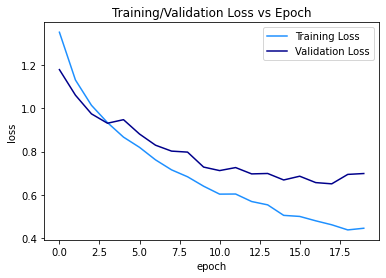

In [15]:
plt.plot(model.history.history['loss'],color='dodgerblue', label='Training Loss')
plt.plot(model.history.history['val_loss'],color='darkblue',label='Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training/Validation Loss vs Epoch')
plt.legend(loc = 'best')
plt.show()

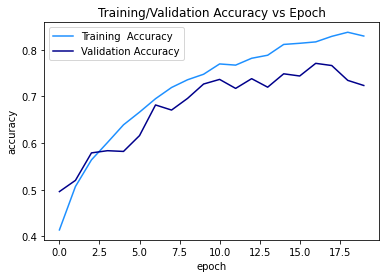

In [16]:
plt.plot(model.history.history['accuracy'],color='dodgerblue', label='Training  Accuracy')
plt.plot(model.history.history['val_accuracy'],color='darkblue', label='Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training/Validation Accuracy vs Epoch')
plt.legend(loc = 'best')
plt.show()

In [31]:
# Test the model!
# Calcuate accuracy, precision, and recall for each class

y_pred = model.predict(X_test)
y_pred_labels = tf.argmax(y_pred, axis=1).numpy()
y_test_labels = tf.argmax(y_test, axis=1).numpy()

precision = precision_score(y_test_labels, y_pred_labels, average=None, zero_division = 1)
recall = recall_score(y_test_labels, y_pred_labels, average=None, zero_division = 1)
# None bc I want precision and recall for EACH class, where with weighted it gives an overall precision and recall

for i in range(6):
    if i < 5:
        print(f"Class {i}: Precision: {precision[i]*100}%, Recall: {recall[i]*100}%")
    else:
        print(f"Class 9: Precision: {precision[-1]*100}%, Recall: {recall[-1]*100}%")

120/120 [==============================] - 4s 31ms/step
Class 0: Precision: 59.350649350649356%, Recall: 69.558599695586%
Class 1: Precision: 76.02373887240356%, Recall: 90.27484143763213%
Class 2: Precision: 84.33862433862433%, Recall: 63.20380650277557%
Class 3: Precision: 61.904761904761905%, Recall: 37.142857142857146%
Class 4: Precision: 86.54434250764525%, Recall: 89.27444794952682%
Class 9: Precision: 44.827586206896555%, Recall: 25.24271844660194%


In [21]:
# overall accuracy
loss, acc = model.evaluate(X_test,y_test)

#overall precision
prec = precision_score(y_test_labels, y_pred_labels, average = 'weighted', zero_division = 1) 
# 1 = Silently ignores the warning and returns 0 for precision scores for labels with no predicted samples

#overall recall
rec = recall_score(y_test_labels, y_pred_labels, average = 'weighted')

print(f'overall accuracy: {acc*100}%, overall precision: {prec*100}%, overall recall: {rec*100}%')

120/120 [==============================] - 4s 31ms/step - loss: 0.7003 - accuracy: 0.7499
overall accuracy: 74.99346733093262%, overall precision: 75.6747318165377%, overall recall: 74.9934674679906%


accuracy per class: [69.5585997  90.27484144 63.2038065  37.14285714 89.27444795 25.24271845]%


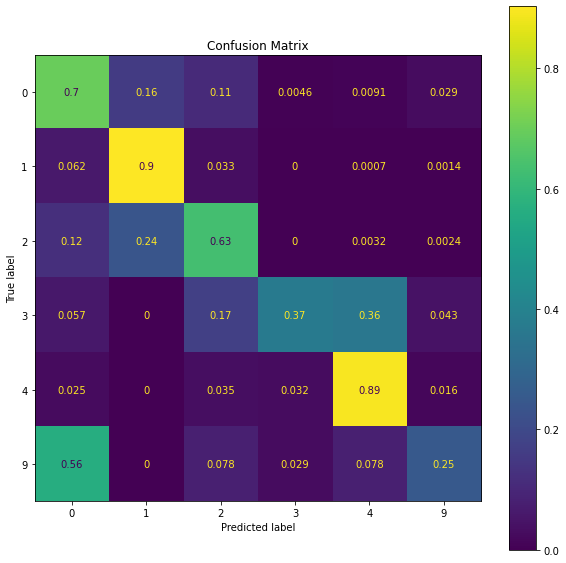

In [44]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, normalize='true')
accuracy = cm.diagonal()/cm.sum(axis=1) # diagonal gives accuracies per class
print(f'accuracy per class: {accuracy*100}%')

#Plot confusion matrix
ticks = np.array([0,1,2,3,4,9])
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=ticks)
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Confusion Matrix')
disp.plot(ax = ax);
plt.show()
#plt.savefig('cm.png')

## Results


- When classes 5-8 are removed from the dataset due to visual similarity to other classes, the CNN performs slightly better. The accuracy, precision, and recall scores are as follows: 75%, 76%, and 75%. These are not great scores, but removing some of the classes did improve them somewhat. 
- The Galaxy10 dataset is an imbalanced dataset, so a lower accuracy score is expected, but 75% is still low. 
- Different CNNs were explored in this project, and they all performed the same. The images in this dataset could be too similar for this model to differentiate between. 
- According to the confusion matrix, the CNN had trouble distinguishing between classes 0 and 9. These two image types were disk face on no spiral and disk face on loose spiral, very similar types.

- An improvement to this project would be to consider the likeness of the images along with their types. By eliminating classes more strategically, the CNN could perform better. 